<b>Logistic regression</b> implementation

Preprocess the Data, removing unecessary attributes and selecting size of training data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [130]:
df = pd.read_csv('star_classification.csv')
df["class"].unique()
df = df[0:70000]
x = df.drop('class', axis=1)
x = x.drop("obj_ID", axis=1)
x = x.drop("spec_obj_ID", axis=1)
y = df['class']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
###
weights = np.zeros( (3, 16) ) #16 attributes in the dataset
iterations = 500
alpha = 0.01    #the learning rate
###
classes = {'GALAXY':0, 'QSO':1, 'STAR':2 }
print(y.unique())
x

['GALAXY' 'QSO' 'STAR']


,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,131.395811,14.702348,23.20784,22.02995,22.55032,22.26056,21.14248,5137,301,2,121,2.403759,5290,55862,478
69996,242.835328,22.028651,25.77823,21.87973,20.27037,19.26547,18.80631,4520,301,3,46,0.472409,3928,55331,405
69997,188.406034,61.852980,19.44353,18.33764,17.73049,17.36151,17.12009,2304,301,2,208,0.152178,781,52373,269
69998,145.948953,55.557558,22.29216,22.50082,21.21581,20.39013,19.65334,2304,301,2,58,0.649600,7283,57063,838


In [131]:
def transformYtoNum(y):
    # Transforms String classes to integers
    y_new = np.zeros((len(y)))
    for i in range(len(y)):
        y_new[i] = classes.get(y[i])

    return y_new

def one_hot_encoding(y):
    
    y_new = []
    for i in range(len(y)):
        y_new.append([1 if y[i] == j else 0 for j in range(3)])
    return np.array(y_new)

In [132]:
# Converting pd frames to numpy arrays
y_train = y_train.to_numpy()
x_train = x_train.to_numpy()
y_test = y_test.to_numpy()
x_test = x_test.to_numpy()


x_train = np.hstack( (np.ones((x_train.shape[0],1) ), x_train) )
x_test = np.hstack( (np.ones((x_test.shape[0],1) ), x_test) )
print(x_train.shape) # 1 column of ones + 15 attributes  


(49000, 16)


Transform Y array to one-hot encoding<br>Example: [0,1,2] -> [[1,0,0], [0,1,0],[0,0,1]]

In [133]:
y_train_transformed = transformYtoNum(y_train)
y_test_transformed = transformYtoNum(y_test)
print("Shape before one hot: ", y_train.shape)

y_train_one_hot = one_hot_encoding(y_train_transformed)
print ("One hot vectors array shape: ", y_train_one_hot.shape)



# prevent OVERFLOW in calculations
scaler=StandardScaler()
x_train_scaler=scaler.fit_transform(x_train)
x_test_scaler=scaler.fit_transform(x_test)

Shape before one hot:  (49000,)
One hot vectors array shape:  (49000, 3)


<b>Stohastic gradient Descent</b><br>
1. Initialize W (weights) array (3,16) with ones.<br>
2. For each Epoch(iteration) shuffle data on x_train, y_train.<br>
3. Calculate Probabilities with SoftMax with the current Weights<br>
4. Calculate Cross-Entropy Loss and Gradient after each batch_size based on the probabilities output from softmax. (Stohastic Gradient Descent)<br>
5. Update W array based on the Gradient Descent from step 4.

<b>predict function</b><br>
1.Compute the SoftMax of X*W.T<br>
2. For each training data pick the category with highest probability output from SoftMax

In [134]:
import time

def predict(x, w, y):
    N, D = x.shape
    preds = np.dot(x, w.T)
    preds_softmax = softmax(preds)
    correct_preds = 0

    for i in range(N):
        if np.argmax(preds_softmax[i]) == y[i]:
            correct_preds += 1

    return correct_preds

def softmax(z):
    #print(z[0:10])
    z = z - np.max(z, axis=1, keepdims=True)  
    
    
    #clipped_z = np.clip(z, 1e-100, None)  # Clip values below 1e-10
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cost_grad_softmax_sgd(W, x, t, lamda):

    E = 0
    N, D = x.shape
    K = t.shape[1]
    
    # SoftMax on the predictions
    y = softmax(np.dot(x, W.T))  
    
    
    # Cross Entropy Loss 
    E += -np.sum(t * np.log(y)) / t.shape[0]
    
    # Regularization
    E += lamda * np.sum( np.square( W ) ) / 2    

    # Calculate Gradient 
    gradEw = -np.dot( (t-y).T, x ) + lamda * W

    return E, gradEw

def train_softmax_sgd(X, T, batch_size, classes_num, W, lamda=0.00001, learning_rate=0.00003, iterations=100):

    test_history = []
    train_history = []
    total_loss_history = []
    W = np.ones((3,16))
    print(W)
    
    N, D = X.shape
    
    

    for iter in range(iterations):

        # Shuffle data
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        T = T[indices]

        total_loss = 0

        for n in range(0, N, batch_size):
            x = X[n:n+batch_size]  # (batch_size, D)
            t = T[n:n+batch_size]  # (batch_size, classes_num)

            # Compute loss and gradient
            E, gradEw = cost_grad_softmax_sgd(W, x, t, lamda)

            # Update weights using SGD
            W -= learning_rate * gradEw
            
            # Accumulate loss for reporting
            total_loss += E
            

        # Report loss after each epoch
        print(f"Epoch {iter + 1}/{iterations}, Loss: {total_loss :.4f}")

        preds_train = predict(x_train_scaler, W, y_train_transformed)
        preds_test = predict(x_test_scaler, W, y_test_transformed)

        total_loss_history.append(total_loss)
        test_history.append(preds_test/len(y_test) * 100)
        train_history.append(preds_train/len(T) * 100)

    
    return W, total_loss_history, test_history, train_history

In [135]:
w_new, total_loss_history, test_history, train_history = train_softmax_sgd(x_train_scaler, y_train_one_hot, 128, 3, weights)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Epoch 1/100, Loss: 374.1513
Epoch 2/100, Loss: 329.5578
Epoch 3/100, Loss: 307.6185
Epoch 4/100, Loss: 294.0160
Epoch 5/100, Loss: 284.6921
Epoch 6/100, Loss: 277.8654
Epoch 7/100, Loss: 272.5475
Epoch 8/100, Loss: 268.3528
Epoch 9/100, Loss: 264.9029
Epoch 10/100, Loss: 262.0086
Epoch 11/100, Loss: 259.5720
Epoch 12/100, Loss: 257.4200
Epoch 13/100, Loss: 255.5326
Epoch 14/100, Loss: 253.8681
Epoch 15/100, Loss: 252.3826
Epoch 16/100, Loss: 251.0336
Epoch 17/100, Loss: 249.8026
Epoch 18/100, Loss: 248.6561
Epoch 19/100, Loss: 247.6352
Epoch 20/100, Loss: 246.7130
Epoch 21/100, Loss: 245.8036
Epoch 22/100, Loss: 244.9729
Epoch 23/100, Loss: 244.2092
Epoch 24/100, Loss: 243.4925
Epoch 25/100, Loss: 242.8071
Epoch 26/100, Loss: 242.1787
Epoch 27/100, Loss: 241.5785
Epoch 28/100, Loss: 241.0139
Epoch 29/100, Loss: 240.4804
Epoch 30/100, 

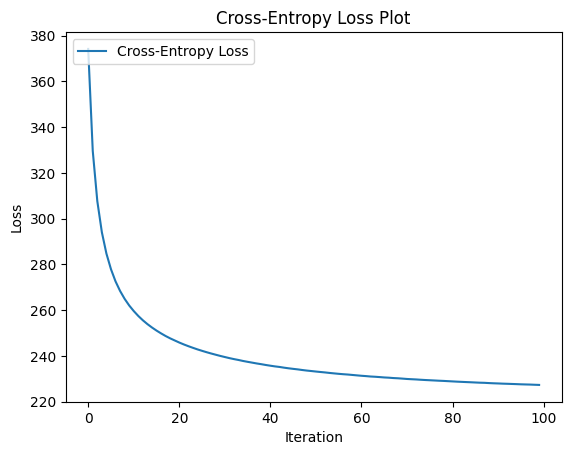

In [141]:
plt.plot( total_loss_history)
#plt.plot( accuracy_history)
plt.title('Cross-Entropy Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Cross-Entropy Loss'], loc='upper left')
plt.show()

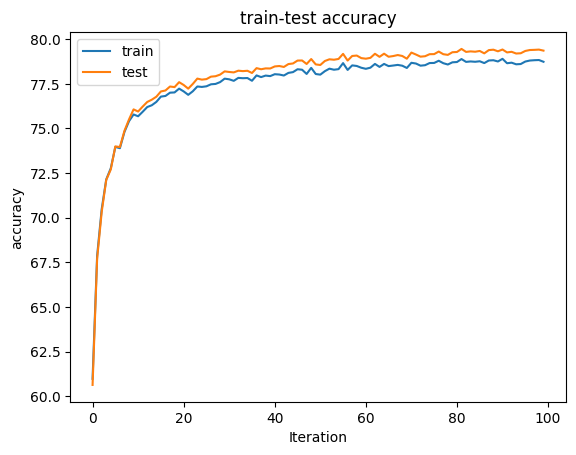

In [137]:
plt.plot( train_history)
plt.plot( test_history)
plt.title('train-test accuracy')
plt.ylabel('accuracy')
plt.xlabel('Iteration')
plt.legend(['train', 'test'], loc='upper left')
plt.show()